In [1]:
# from utils_preproc.utils import *
from manuscript_functions.colors import blast_vs_rest, id_cmap, remission_and_prediction, timepoints_cmap, default_hex, default_cmap, patient_to_id
from manuscript_functions.model_evaluation import get_blast_prop, plot_mispredicted_blast_fraction_per_file
from manuscript_functions.model_utils import find_and_load_checkpoint, preprocess, get_run_meta
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_context("paper")

In [3]:
rel_error = False
AE=True
mix_file = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Synthetic_mix/Raw/CC_incl_low_expr_test/0.5_healthy_expr.csv"
mix_meta = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Synthetic_mix/Raw/CC_incl_low_expr_test/0.5_healthy_meta.csv"
all_expr = "/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/Raw/myeloid_expr_raw.csv"
all_meta = "/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/local_all_cells_meta_clust_celltype.csv"
Y1 = np.load("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/Transformed_normalised/UMAP_Y1_all_expr_transformed_normalised.npy")

In [4]:
patient_meta = pd.read_excel("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/metadata_patients_20221007.xlsx")
cell_meta = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/monocytic_meta_TP_patient_file_cluster.csv", index_col=0)

meta = pd.read_csv(all_meta, index_col=0).reset_index(drop=True)
expr = pd.read_csv(all_expr, index_col=0).reset_index(drop=True)

meta["PatientID"] = [patient_to_id[p] for p in meta["patient_id"]]
cell_meta["PatientID"] = [patient_to_id[p] for p in cell_meta["patient_id"]]


blast_anno_files = meta[meta["cell_type"]=="Blast"].groupby("file_id").size()[meta[meta["cell_type"]=="Blast"].groupby("file_id").size()>100].index.to_list()




In [5]:
patient_meta.rename(columns={"USI": "patient_id", 
                             "Bone marrow leukemic blast percentage (%) at diagnosis": "Diagnosis",
                             "Bone marrow leukemic blast percentage (%) at relapse": "Relapse"}, inplace=True)
patient_meta["PatientID"] = [patient_to_id[p] for p in patient_meta["patient_id"]]
temp = patient_meta[["patient_id", "Diagnosis", "Relapse", "PatientID"]]
temp = pd.melt(temp, id_vars=["patient_id", "PatientID"], value_vars=["Diagnosis", "Relapse"],
               var_name="time_point", value_name="perc_blast")
file_ids = cell_meta[["patient_id", "time_point", "file_id", "PatientID"]].drop_duplicates().reset_index(drop=True)
clinical_data = pd.merge(file_ids, temp, how="outer").sort_values("file_id")
clinical_data

,patient_id,time_point,file_id,PatientID,perc_blast
0,PAUMTZ,Diagnosis,0.0,P1,86.0
1,PAUMTZ,Relapse,1.0,P1,82.0
2,PAUZTH,Diagnosis,2.0,P4,40.0
3,PAUZTH,Relapse,3.0,P4,84.0
4,PAUZVP,Diagnosis,4.0,P12,79.0
5,PAUZVP,Relapse,5.0,P12,75.0
6,PAVDZK,Relapse,6.0,P13,96.0
7,PAVEDT,Diagnosis,7.0,P14,92.4
8,PAVEDT,Relapse,8.0,P14,93.0
9,PAVRJP,Diagnosis,9.0,P2,78.0


In [6]:
# checkpoint = "epoch=19-step=980-v2.ckpt"
run_dir = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Choosen_model/autoencoder_0.9/"
# model, scaler = find_and_load_checkpoint(run_id=None, run_dir=run_dir, client=None, AE=AE, old_CV=False, ckpt_name=checkpoint)
# trans_norm_expr = pd.DataFrame(preprocess(expr, scaler, do_transform=True), columns=expr.columns)

In [7]:
# Load predictions
path = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Experiments/sklear_models/LCO/L1O/"
svm_pred = np.load(f"{path}svm_prediction.npy")

In [8]:
run_meta = get_run_meta(run_id=None, runs=None, client=None, 
                        expr_file=all_expr, meta_file=all_meta, 
                        thresh_mix_file=None, thresh_mix_meta=None,
                        inc_rel_error=False, old_CV=False, transform_syn_mix=True,
                        run_dir=run_dir)
run_meta[["UMAP1", "UMAP2"]] = Y1

In [9]:
annotated_run_meta_bool = (run_meta["time_point"]=="EOI I") | (run_meta["cell_type"]=="Blast")
annotated_blast_bool = run_meta["cell_type"] == "Blast"
run_meta.loc[annotated_run_meta_bool, "Annotation"] = ["Healthy" if tp=="EOI I" else "Blast" for tp in run_meta.loc[annotated_run_meta_bool, "time_point"]]


In [10]:
run_meta["Prediction"] = svm_pred
run_meta["PatientID"] = [patient_to_id[p] for p in run_meta["patient_id"]]

Overall accuracy: 0.9600958120404434
Blast accuracy: 0.9582711533498648


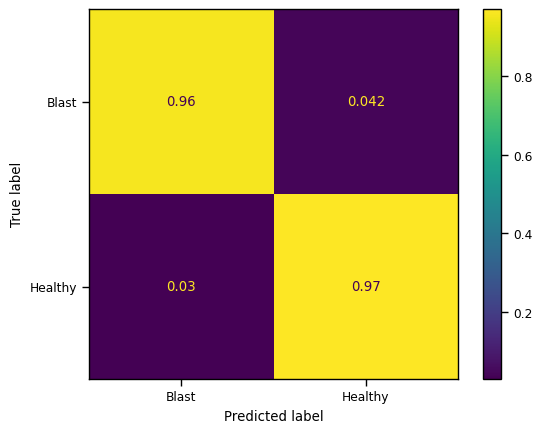

In [11]:
p = ConfusionMatrixDisplay.from_predictions(run_meta.loc[annotated_run_meta_bool, "Annotation"], 
                                        run_meta.loc[annotated_run_meta_bool, "Prediction"],
                                        normalize="true")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/Model_prediciton_confusion_matrix.pdf")
svm_acc = accuracy_score(run_meta.loc[annotated_run_meta_bool, "Annotation"], run_meta.loc[annotated_run_meta_bool, "Prediction"])
svm_b_acc = accuracy_score(run_meta.loc[annotated_blast_bool, "Annotation"], run_meta.loc[annotated_blast_bool, "Prediction"])
print(f"Overall accuracy: {svm_acc}")
print(f"Blast accuracy: {svm_b_acc}")



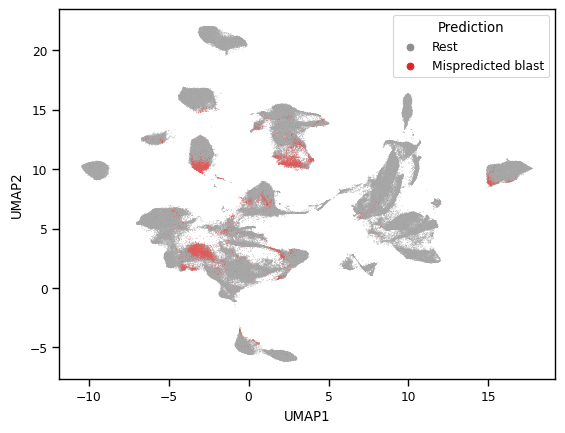

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


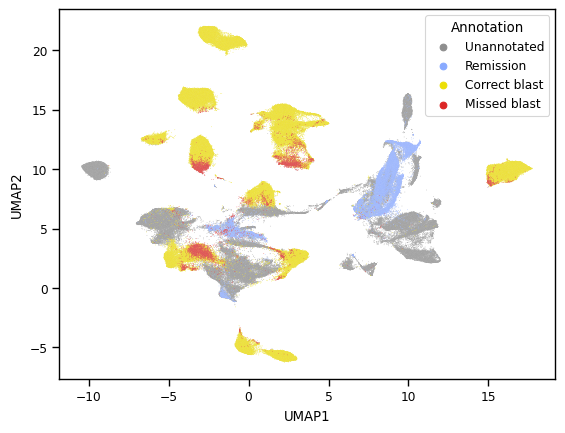

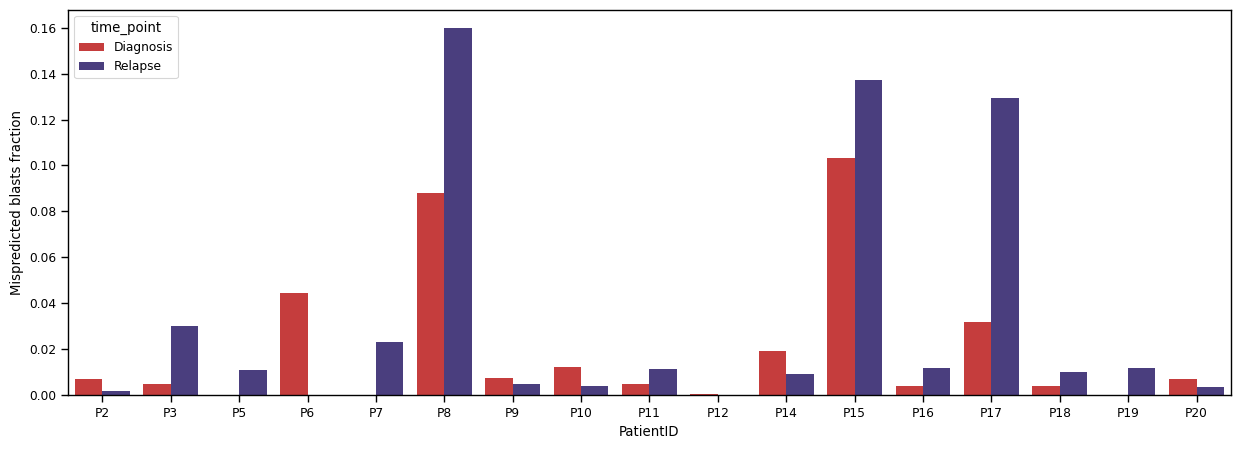

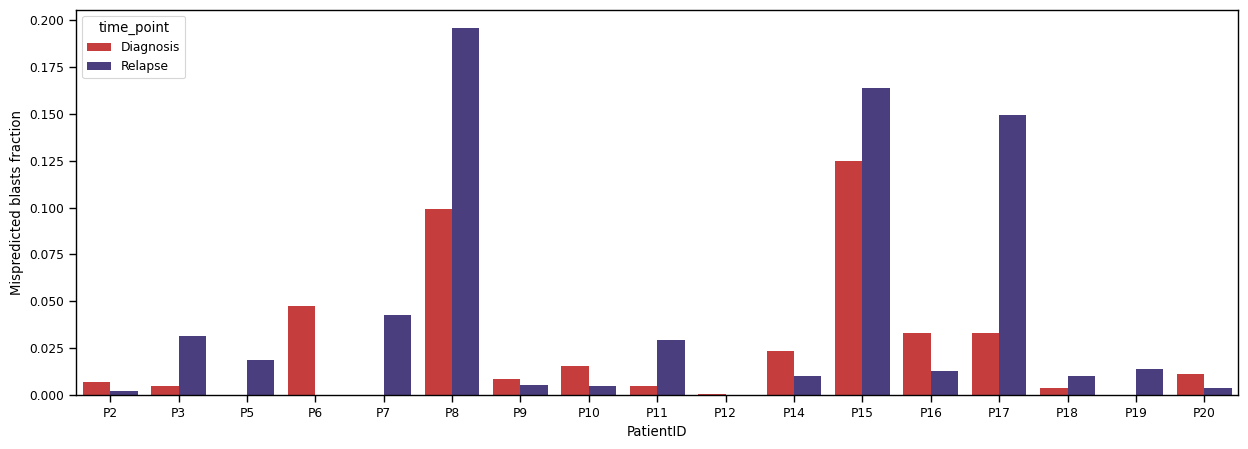

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_38600/4111091092.py:41: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  plot_data = pd.melt(perc_prop, id_vars=["PatientID", "time_point", "file_id"],


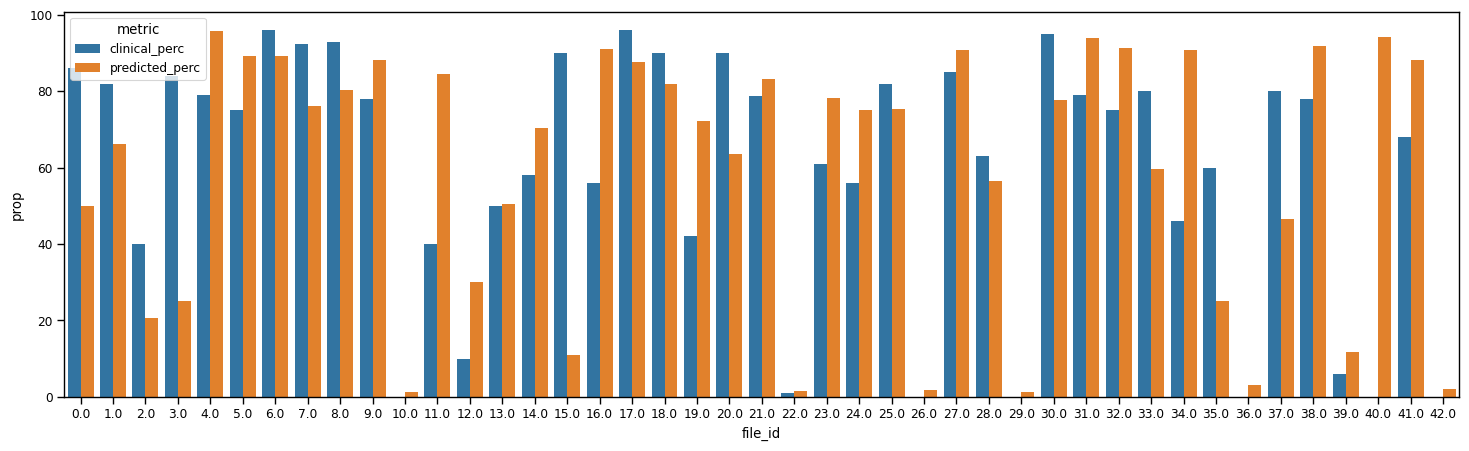

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_38600/4111091092.py:47: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  plot_data = pd.melt(perc_prop, id_vars=["PatientID", "time_point", "file_id"],


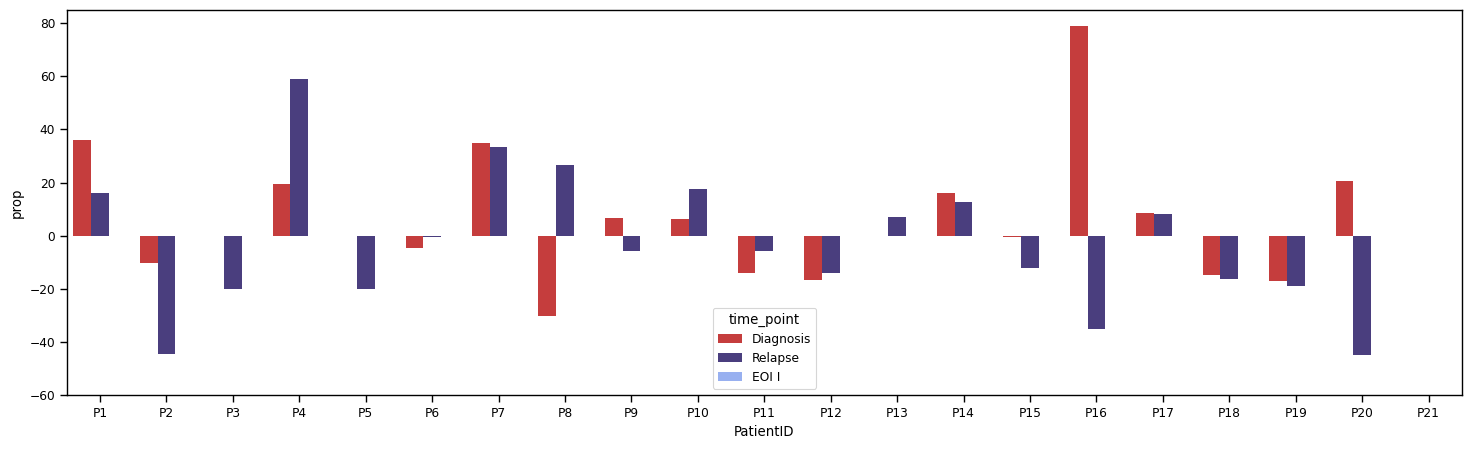

In [12]:
color = ["Mispredicted blast" if bool_ else "Rest" for bool_ in (run_meta["Prediction"]=="Healthy" ) & (run_meta["cell_type"]=="Blast").reset_index(drop=True)]
umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"], "Prediction": color})
umap_data.sort_values("Prediction", ascending=False, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Prediction", palette=[default_hex["grey"], default_hex["red"]])
plt.show()


umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"]})
umap_data.loc[((run_meta["Prediction"]=="Healthy") & (run_meta["Annotation"]=="Blast")), "Annotation"] = "Missed blast"
umap_data.loc[((run_meta["Prediction"]=="Blast") & (run_meta["Annotation"]=="Blast")), "Annotation"] = "Correct blast"
umap_data.loc[(run_meta["time_point"]=="EOI I"), "Annotation"] = "Remission"
umap_data.loc[(umap_data["Annotation"].isna()), "Annotation"] = "Unannotated"
umap_data["Annotation"] = umap_data["Annotation"].astype("category")
umap_data["Annotation"].cat.set_categories(["Unannotated", "Remission", "Correct blast", "Missed blast"], ordered=True, inplace=True)
umap_data.sort_values("Annotation", ascending=True, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Annotation", palette=remission_and_prediction)
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/UMAP_predictions_remission_unannotated.png",
           dpi=300)
plt.show()


# Mis predicted blast fraction
p = plot_mispredicted_blast_fraction_per_file(run_meta, blast_files=blast_anno_files, cmap=timepoints_cmap)
plt.show()
plt.close()
p = plot_mispredicted_blast_fraction_per_file(run_meta, blast_files=blast_anno_files, reference="blasts", cmap=timepoints_cmap)
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/barplot_fraction_of_blasts_mispredicted_for_annotated_files.pdf")
plt.show()
plt.close()


# Compare to clinical data
prop = get_blast_prop(run_meta, full_file_size=True)
blast_prop = prop.loc[(prop["Prediction"]=="Blast"), 
                  ["file_id", "time_point", "PatientID", "prop"]].reset_index(drop=True)
blast_prop["predicted_perc"] = [p*100 for p in blast_prop["prop"]] 
perc_prop = pd.merge(clinical_data, blast_prop, how="outer")
perc_prop.rename(columns={"perc_blast": "clinical_perc"}, inplace=True)
perc_prop["diff"] = perc_prop["clinical_perc"]-perc_prop["predicted_perc"]

plot_data = pd.melt(perc_prop, id_vars=["PatientID", "time_point", "file_id"], 
                    value_vars=["clinical_perc", "predicted_perc", "diff"], value_name="prop", var_name="metric")
plt.figure(figsize=(18,5))
sns.barplot(data=plot_data[plot_data["metric"]!="diff"], x="file_id", y="prop", hue="metric")
plt.show()

plot_data = pd.melt(perc_prop, id_vars=["PatientID", "time_point", "file_id"], 
                value_vars=["clinical_perc", "predicted_perc", "diff"], value_name="prop", var_name="metric")
plot_data = plot_data.sort_values("PatientID", key=lambda idx: [int(x.replace("P", "")) for x in idx])
plt.figure(figsize=(18,5))
f = sns.barplot(data=plot_data[plot_data["metric"]=="diff"], x="PatientID", y="prop", hue="time_point", palette=timepoints_cmap)
f.set_ylim(-60, 85)
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/barplot_difference_predicted_and_clinical_blast_percentage.pdf")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/barplot_difference_predicted_and_clinical_blast_percentage.png")
plt.show()

In [16]:
perc_prop.to_csv("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/clinical_vs_pred_percentage.csv")

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


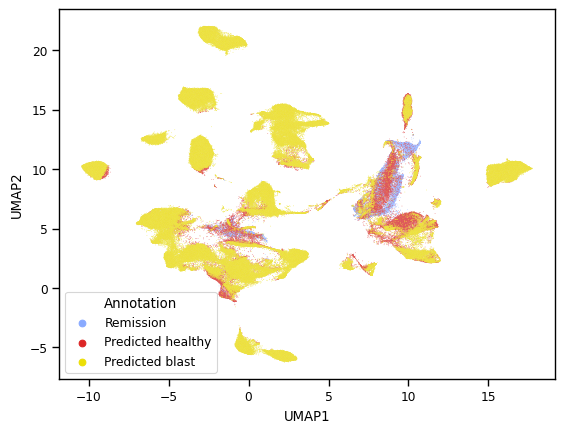

In [13]:
umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"]})
umap_data.loc[((run_meta["Prediction"]=="Healthy") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted healthy"
umap_data.loc[((run_meta["Prediction"]=="Blast") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted blast"
umap_data.loc[(run_meta["time_point"]=="EOI I"), "Annotation"] = "Remission"
umap_data["Annotation"] = umap_data["Annotation"].astype("category")
umap_data["Annotation"].cat.set_categories(["Remission", "Predicted healthy", "Predicted blast"], ordered=True, inplace=True)
umap_data.sort_values("Annotation", ascending=True, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Annotation", palette=remission_and_prediction)
plt.show()

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


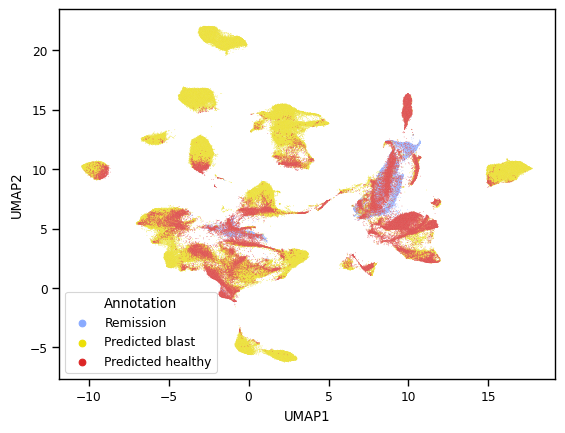

In [14]:
umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"]})
umap_data.loc[((run_meta["Prediction"]=="Healthy") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted healthy"
umap_data.loc[((run_meta["Prediction"]=="Blast") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted blast"
umap_data.loc[(run_meta["time_point"]=="EOI I"), "Annotation"] = "Remission"
umap_data["Annotation"] = umap_data["Annotation"].astype("category")
umap_data["Annotation"].cat.set_categories(["Remission", "Predicted blast", "Predicted healthy"], ordered=True, inplace=True)
umap_data.sort_values("Annotation", ascending=True, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Annotation", palette=remission_and_prediction)
plt.show()

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


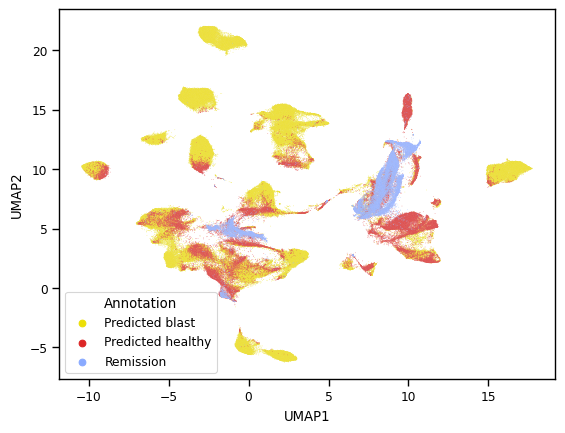

In [15]:
umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"]})
umap_data.loc[((run_meta["Prediction"]=="Healthy") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted healthy"
umap_data.loc[((run_meta["Prediction"]=="Blast") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted blast"
umap_data.loc[(run_meta["time_point"]=="EOI I"), "Annotation"] = "Remission"
umap_data["Annotation"] = umap_data["Annotation"].astype("category")
umap_data["Annotation"].cat.set_categories(["Predicted blast", "Predicted healthy", "Remission"], ordered=True, inplace=True)
umap_data.sort_values("Annotation", ascending=True, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Annotation", alpha=0.8, palette=remission_and_prediction)
plt.show()

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


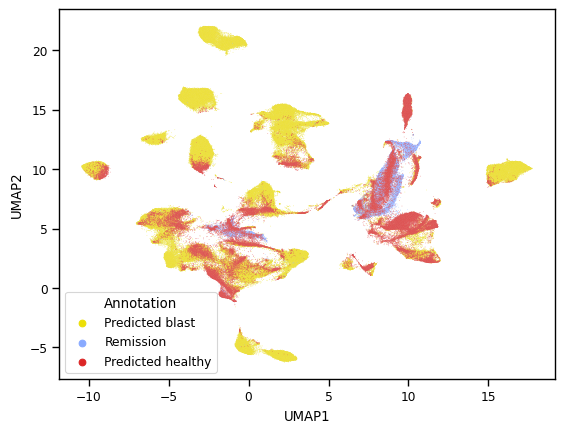

In [16]:
umap_data = pd.DataFrame({"UMAP1":run_meta["UMAP1"], "UMAP2": run_meta["UMAP2"]})
umap_data.loc[((run_meta["Prediction"]=="Healthy") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted healthy"
umap_data.loc[((run_meta["Prediction"]=="Blast") & (run_meta["time_point"]!="EOI I")), "Annotation"] = "Predicted blast"
umap_data.loc[(run_meta["time_point"]=="EOI I"), "Annotation"] = "Remission"
umap_data["Annotation"] = umap_data["Annotation"].astype("category")
umap_data["Annotation"].cat.set_categories(["Predicted blast", "Remission", "Predicted healthy"], ordered=True, inplace=True)
umap_data.sort_values("Annotation", ascending=True, inplace=True)
sns.scatterplot(data = umap_data, x="UMAP1", y="UMAP2", s=0.2, hue="Annotation", alpha=0.8, palette=remission_and_prediction)
plt.show()

# Marker errors

In [17]:
errors = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Data/all_marker_errors.csv", 
                     index_col=0)
markers = list(errors.columns)

In [18]:
TP = (run_meta["Prediction"] == "Blast")   & (run_meta["cell_type"]=="Blast")
TN = (run_meta["Prediction"] == "Healthy") & (run_meta["time_point"]=="EOI I")
FP = (run_meta["Prediction"] == "Blast")   & (run_meta["time_point"]=="EOI I")
FN = (run_meta["Prediction"] == "Healthy") & (run_meta["cell_type"]=="Blast")

run_meta["TP"] = TP.astype(int)
run_meta["TN"] = TN.astype(int)
run_meta["FP"] = FP.astype(int)
run_meta["FN"] = FN.astype(int)

run_meta.loc[TP, "Correct_prediction"] = 1
run_meta.loc[TN, "Correct_prediction"] = 1
run_meta.loc[FP, "Correct_prediction"] = 0
run_meta.loc[FN, "Correct_prediction"] = 0

conf_errors = errors.copy()
conf_errors.loc[run_meta["TP"]==1, "Conf_matrix"] = "TP"
conf_errors.loc[run_meta["TN"]==1, "Conf_matrix"] = "TN"
conf_errors.loc[run_meta["FP"]==1, "Conf_matrix"] = "FP"
conf_errors.loc[run_meta["FN"]==1, "Conf_matrix"] = "FN"

In [19]:
conf_pld = conf_errors.dropna(subset="Conf_matrix")
conf_pld = conf_pld.melt(id_vars = "Conf_matrix", value_vars = markers, var_name="Marker", value_name="Squared_error")


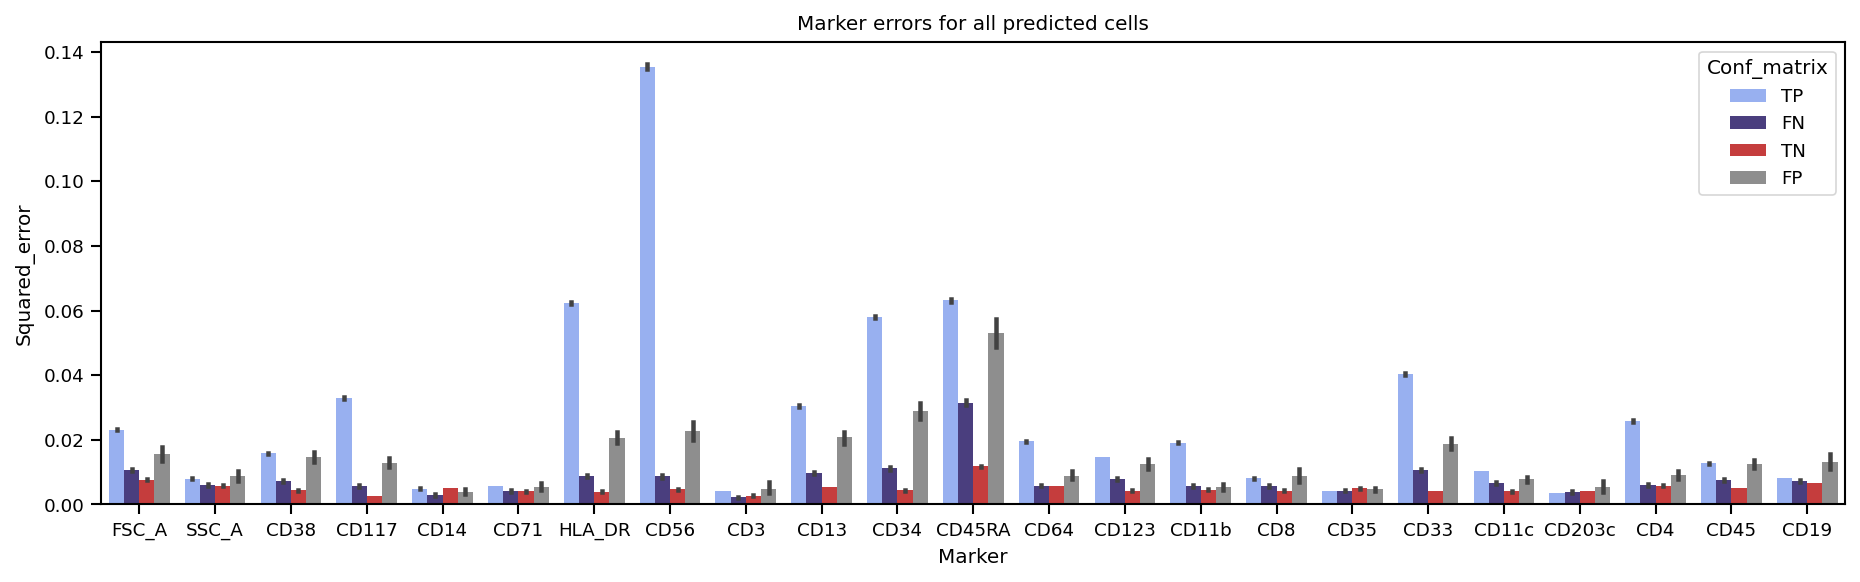

In [20]:
plt.figure(figsize=(15,4), dpi=150)
sns.barplot(data=conf_pld, x="Marker", y="Squared_error", hue="Conf_matrix", palette=default_cmap[:4])
plt.title("Marker errors for all predicted cells")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure2/All_predicted_cells_conf_matrix_marker_errors.pdf")
plt.show()

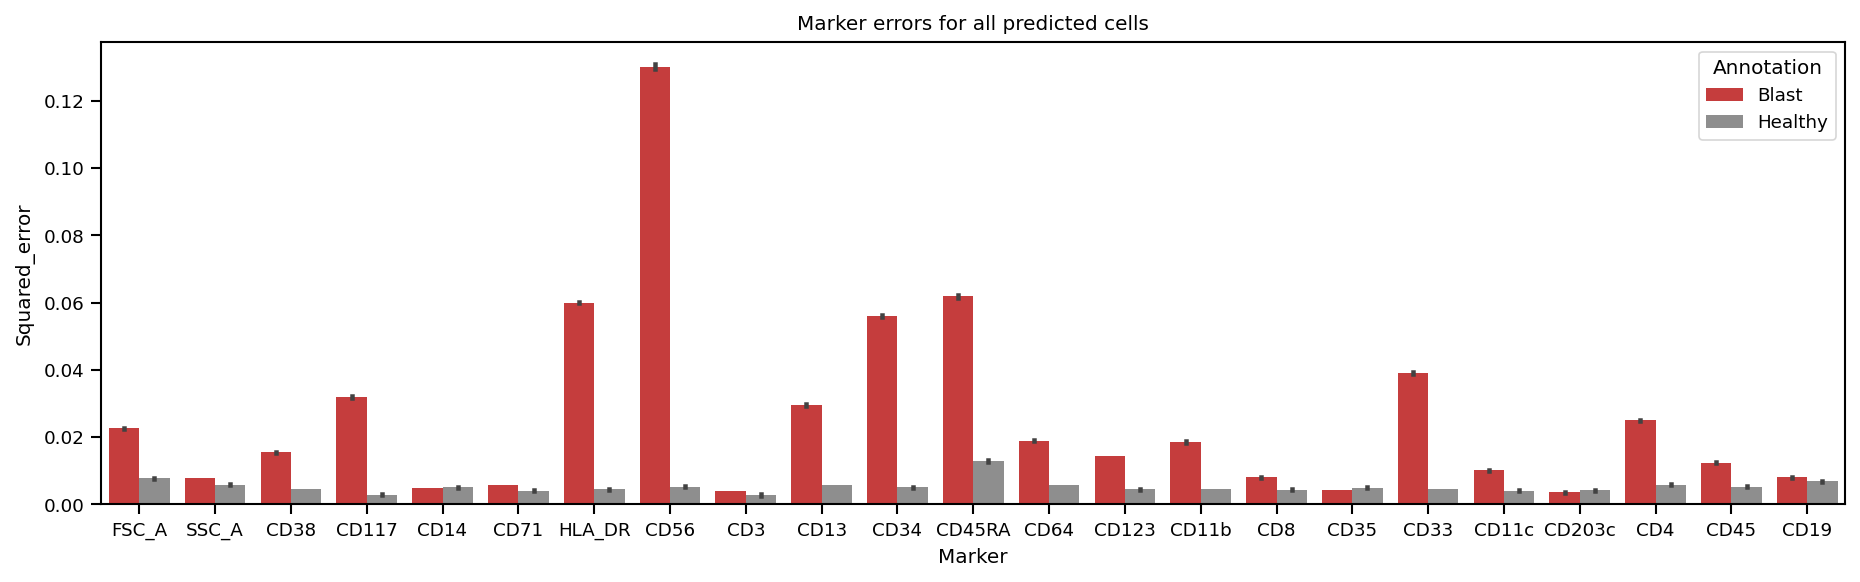

In [21]:
conf_pld["Annotation"] = ["Blast" if label in ["TP", "FN"] else "Healthy" for label in conf_pld["Conf_matrix"]]
plt.figure(figsize=(15,4), dpi=150)
sns.barplot(data=conf_pld, x="Marker", y="Squared_error", hue="Annotation", palette=[default_hex["red"], default_hex["grey"]])
plt.title("Marker errors for all predicted cells")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure2/All_annotated_cells_conf_matrix_marker_errors.pdf")
plt.show()

# Plots and data for analysis

In [22]:
perc_prop.to_excel("/Users/adr/Box/iPC_AML/Figures/updated_fcs/predicted_blast_prop_in_files_and_clinical_report.xlsx")
perc_prop

,patient_id,time_point,file_id,PatientID,clinical_perc,prop,predicted_perc,diff
0,PAUMTZ,Diagnosis,0.0,P1,86.0,0.4994,49.94,36.06
1,PAUMTZ,Relapse,1.0,P1,82.0,0.6610,66.10,15.90
2,PAUZTH,Diagnosis,2.0,P4,40.0,0.2053,20.53,19.47
3,PAUZTH,Relapse,3.0,P4,84.0,0.2518,25.18,58.82
4,PAUZVP,Diagnosis,4.0,P12,79.0,0.9582,95.82,-16.82
5,PAUZVP,Relapse,5.0,P12,75.0,0.8913,89.13,-14.13
6,PAVDZK,Relapse,6.0,P13,96.0,0.8913,89.13,6.87
7,PAVEDT,Diagnosis,7.0,P14,92.4,0.7622,76.22,16.18
8,PAVEDT,Relapse,8.0,P14,93.0,0.8027,80.27,12.73
9,PAVRJP,Diagnosis,9.0,P2,78.0,0.8829,88.29,-10.29


In [23]:
# p = plot_mispredicted_blast_fraction_per_file(run_meta, blast_files=blast_anno_files, reference="blasts", cmap=timepoints_cmap)

blast_files = blast_anno_files

# Mis predicted blast fraction
crit = (
    (run_meta["cell_type"] == "Blast")
    & (run_meta["Prediction"] == "Healthy")
    & (run_meta["file_id"].isin(blast_files))
)
temp = (
    run_meta[crit]
    .groupby(["PatientID", "time_point", "file_id"])
    .size()
    .reset_index(drop=False)
    .rename(columns={0: "False Negatives"})
)
size_crit = (run_meta["file_id"].isin(temp["file_id"])) & (
        run_meta["Prediction"] == "Blast"
    )

temp2 = (
    run_meta[size_crit]
    .groupby(["PatientID", "time_point", "file_id"])
    .size()
    .reset_index(drop=False)
    .rename(columns={0: "Size"})
)
temp["Mispredicted blasts fraction"] = temp["False Negatives"] / temp2["Size"] * 100
temp.sort_values("Mispredicted blasts fraction", ascending=False)

,PatientID,time_point,file_id,False Negatives,Mispredicted blasts fraction
26,P8,Relapse,20,1242,19.565217
8,P15,Relapse,14,1151,16.382010
12,P17,Relapse,18,1222,14.933399
7,P15,Diagnosis,13,630,12.502481
25,P8,Diagnosis,19,716,9.926522
23,P6,Diagnosis,21,393,4.718454
24,P7,Relapse,37,199,4.274055
11,P17,Diagnosis,17,289,3.298334
9,P16,Diagnosis,15,36,3.281677
21,P3,Relapse,41,277,3.142015


In [24]:
temp

,PatientID,time_point,file_id,False Negatives,Mispredicted blasts fraction
0,P10,Diagnosis,28,88,1.554770
1,P10,Relapse,30,35,0.451147
2,P11,Diagnosis,38,43,0.467798
3,P11,Relapse,39,35,2.956081
4,P12,Diagnosis,4,3,0.031309
5,P14,Diagnosis,7,179,2.348465
6,P14,Relapse,8,83,1.034010
7,P15,Diagnosis,13,630,12.502481
8,P15,Relapse,14,1151,16.382010
9,P16,Diagnosis,15,36,3.281677


In [25]:
plt_data = get_blast_prop(run_meta, plot=False, full_file_size=False)
plt_data = plt_data.sort_values("PatientID", key=lambda idx: [int(x.replace("P", "")) for x in idx])
plt_data

,file_id,time_point,PatientID,size,Prediction,counts,prop
0,0,Diagnosis,P1,9413,Blast,4994,0.530543
1,0,Diagnosis,P1,9413,Healthy,4419,0.469457
2,1,Relapse,P1,9203,Blast,6610,0.718244
3,1,Relapse,P1,9203,Healthy,2593,0.281756
20,10,EOI I,P2,6407,Blast,113,0.017637
...,...,...,...,...,...,...,...
68,34,Relapse,P20,9157,Blast,9080,0.991591
67,33,Diagnosis,P20,9357,Healthy,3402,0.363578
66,33,Diagnosis,P20,9357,Blast,5955,0.636422
84,42,EOI I,P21,6263,Blast,206,0.032892


Text(0.5, 1.0, 'Fraction of cells predicted to be blasts in only_Progenitors_and_Myeloid cells')

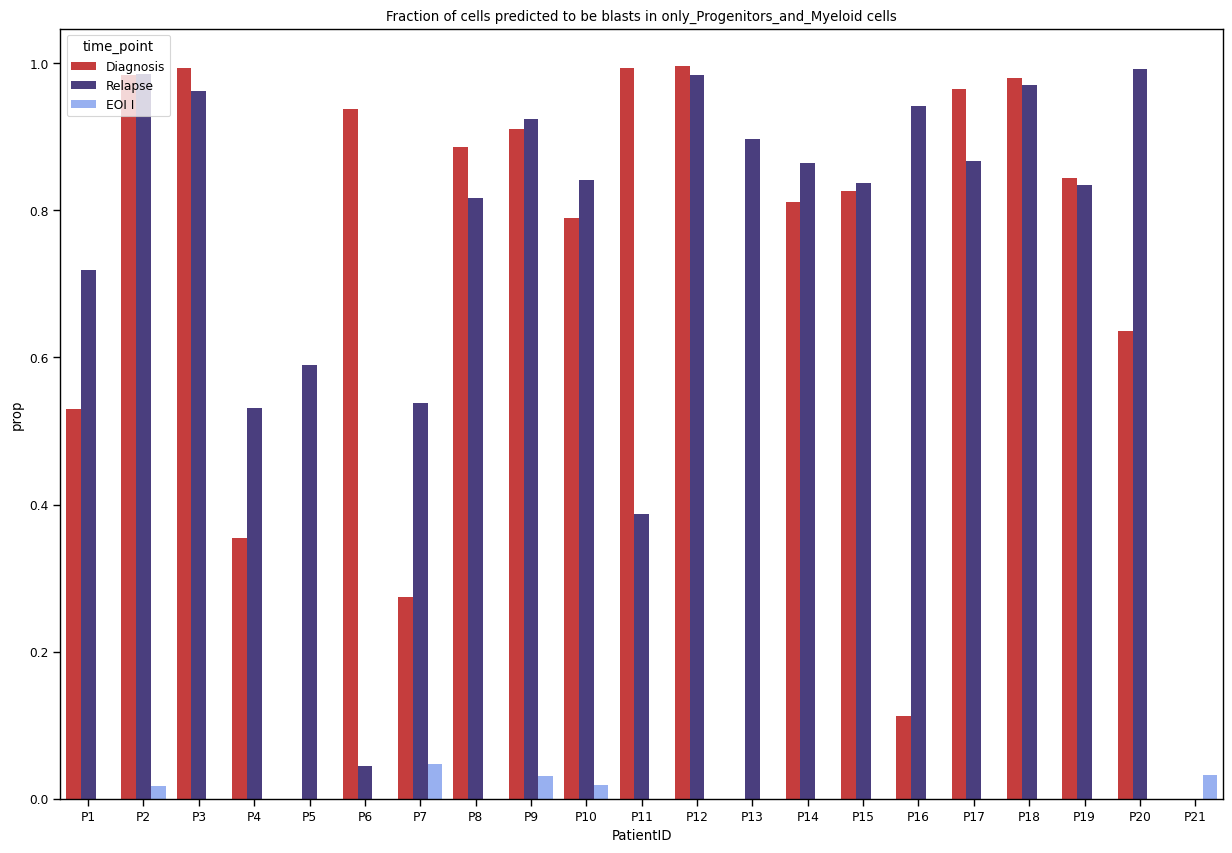

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(data=plt_data[plt_data["Prediction"]=="Blast"], x="PatientID", y="prop", hue="time_point", dodge=True,
           palette=timepoints_cmap)
plt.title("Fraction of cells predicted to be blasts in only_Progenitors_and_Myeloid cells")

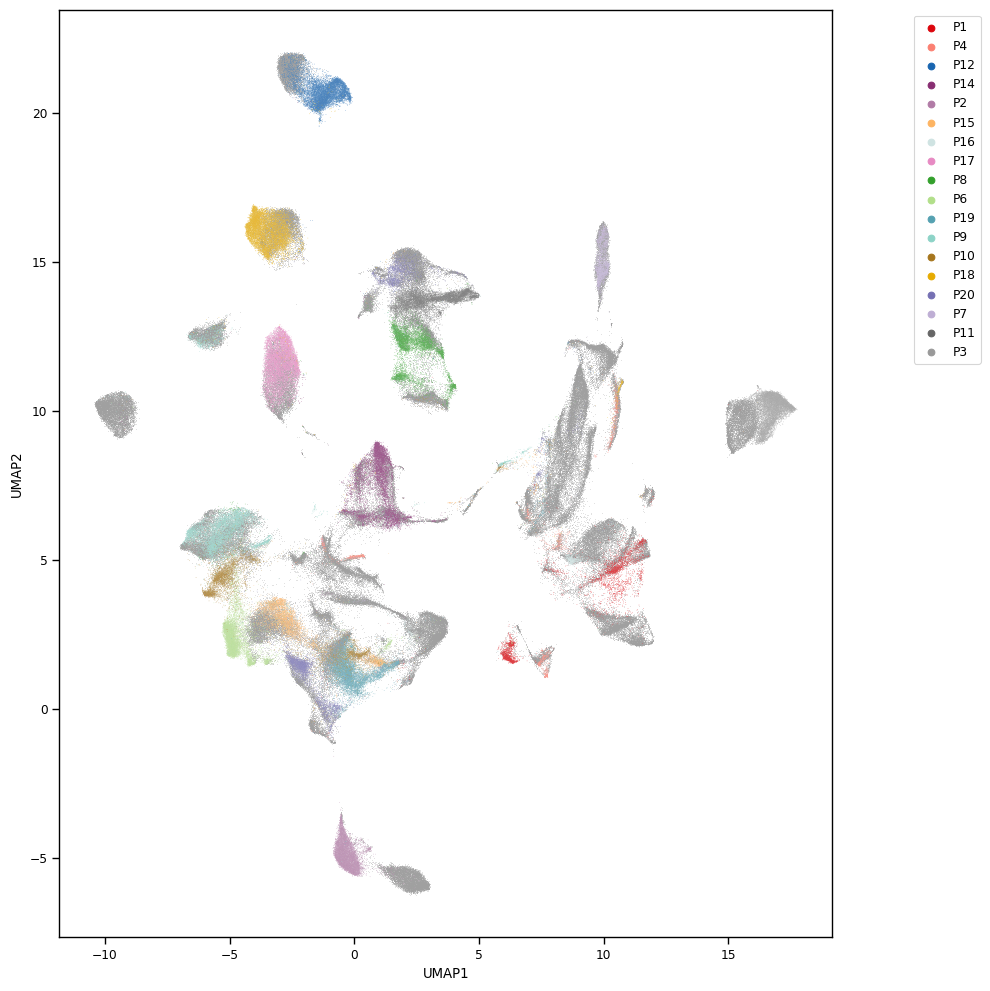

In [27]:
# Diagnosis
plt.figure(figsize=(10,10))
rest = run_meta.loc[(run_meta["Prediction"]=="Healthy")|(run_meta["time_point"]!="Diagnosis"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]
predicted_blasts = run_meta.loc[(run_meta["Prediction"]=="Blast")&(run_meta["time_point"]=="Diagnosis"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]

sns.scatterplot(data = rest, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, color="grey")
sns.scatterplot(data = predicted_blasts, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, hue="PatientID", palette=id_cmap)
plt.legend(bbox_to_anchor=(0.2,0,1,1))
plt.tight_layout()
plt.savefig("/Users/adr/Box/iPC_AML/Figures/updated_fcs/UMAPs/Diagnosis_blasts_highlighted.png")
plt.show()

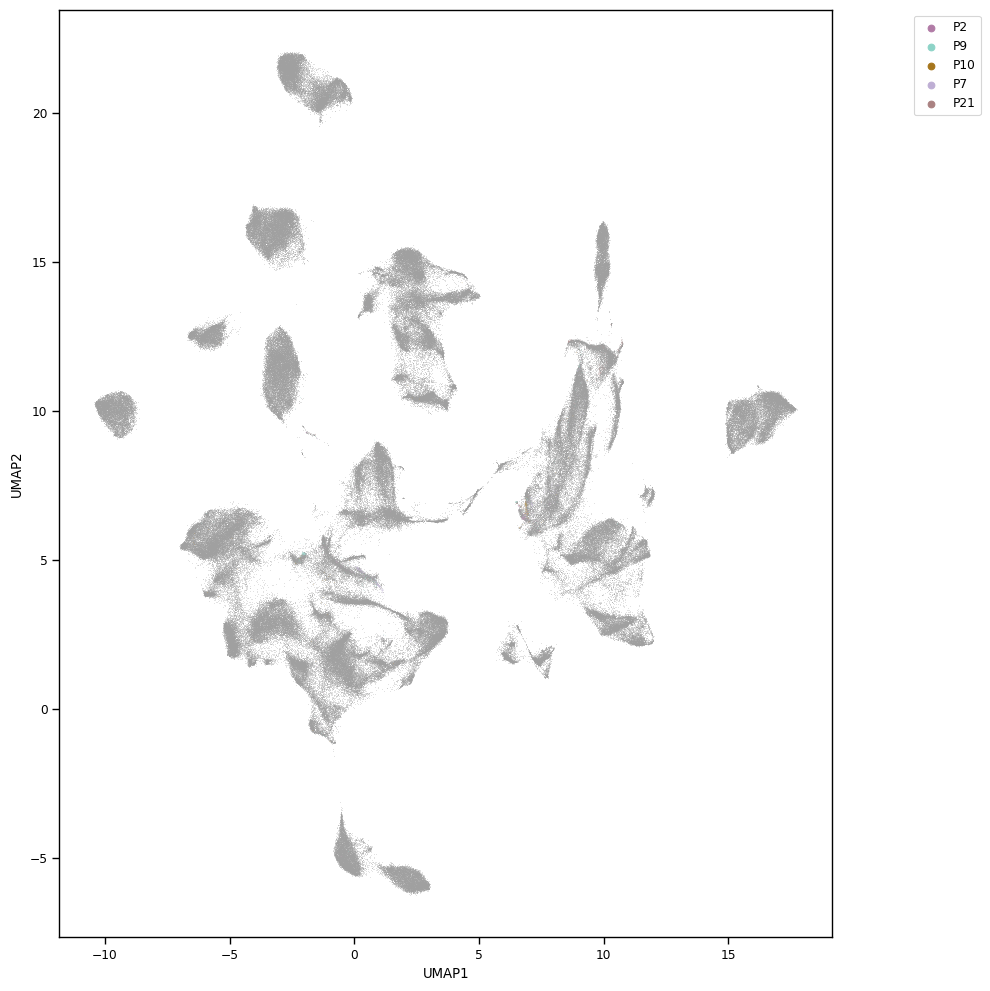

In [28]:
# Remission
plt.figure(figsize=(10,10))
rest = run_meta.loc[(run_meta["Prediction"]=="Healthy")|(run_meta["time_point"]!="EOI I"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]
predicted_blasts = run_meta.loc[(run_meta["Prediction"]=="Blast")&(run_meta["time_point"]=="EOI I"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]

sns.scatterplot(data = rest, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, color="grey")
sns.scatterplot(data = predicted_blasts, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, hue="PatientID", 
               palette=id_cmap)
plt.legend(bbox_to_anchor=(0.2,0,1,1))
plt.tight_layout()
plt.savefig("/Users/adr/Box/iPC_AML/Figures/updated_fcs/UMAPs/Remission_blasts_highlighted.png")
plt.show()

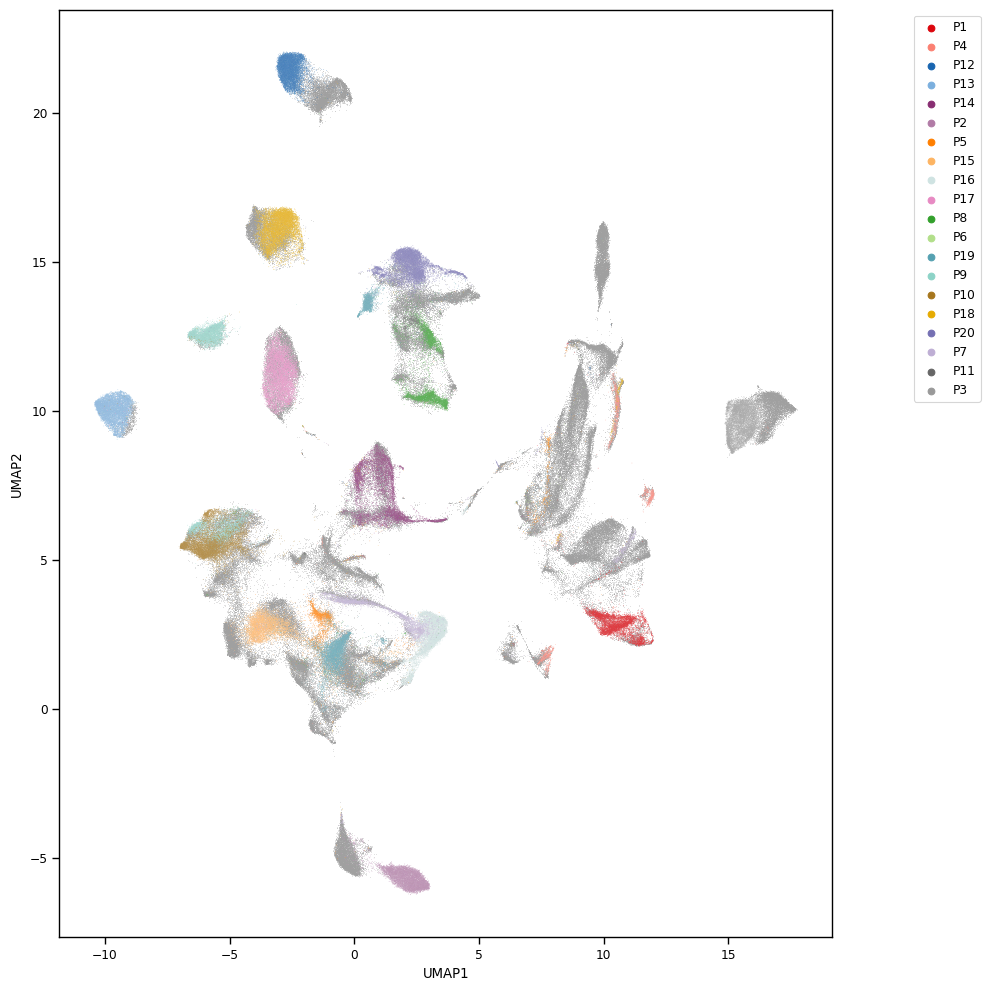

In [29]:
# Relapse

plt.figure(figsize=(10,10))
rest = run_meta.loc[(run_meta["Prediction"]=="Healthy")|(run_meta["time_point"]!="Relapse"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]
predicted_blasts = run_meta.loc[(run_meta["Prediction"]=="Blast")&(run_meta["time_point"]=="Relapse"), ["UMAP1", "UMAP2", "PatientID", "time_point"]]

sns.scatterplot(data = rest, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, color="grey")
sns.scatterplot(data = predicted_blasts, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, hue="PatientID", 
               palette=id_cmap)
plt.legend(bbox_to_anchor=(0.2,0,1,1))
plt.tight_layout()
plt.savefig("/Users/adr/Box/iPC_AML/Figures/updated_fcs/UMAPs/Relapse_blasts_highlighted.png")
plt.show()

In [30]:
run_meta

,time_point,patient_id,file_id,cluster_id,healthy_cluster,cell_type,nh_cluster,mse,Prediction,UMAP1,...,enc2,enc3,enc4,Annotation,PatientID,TP,TN,FP,FN,Correct_prediction
0,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.017091,Blast,10.380415,...,-0.405830,0.064351,-0.156649,NaN,P1,0,0,0,0,NaN
1,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.019936,Healthy,11.450223,...,-0.420474,-0.192542,-0.136873,NaN,P1,0,0,0,0,NaN
2,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.015560,Healthy,10.950638,...,-0.601863,0.505226,0.015340,NaN,P1,0,0,0,0,NaN
3,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.022286,Blast,11.503924,...,-0.777660,0.318589,0.266440,NaN,P1,0,0,0,0,NaN
4,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.003863,Healthy,8.018051,...,0.459058,-0.440667,-0.254009,NaN,P1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350245,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.010354,Healthy,9.071080,...,-0.432760,0.243133,0.730975,Healthy,P21,0,1,0,0,1.0
350246,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.002881,Healthy,9.651817,...,-0.826888,0.187653,0.591443,Healthy,P21,0,1,0,0,1.0
350247,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.004404,Healthy,9.876654,...,-1.094499,0.251027,0.323422,Healthy,P21,0,1,0,0,1.0
350248,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.005211,Healthy,9.165490,...,-0.699730,0.357821,1.029119,Healthy,P21,0,1,0,0,1.0


In [31]:
sorted(run_meta["PatientID"].unique(), key=lambda x: int(x.replace("P", "")))

['P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21']

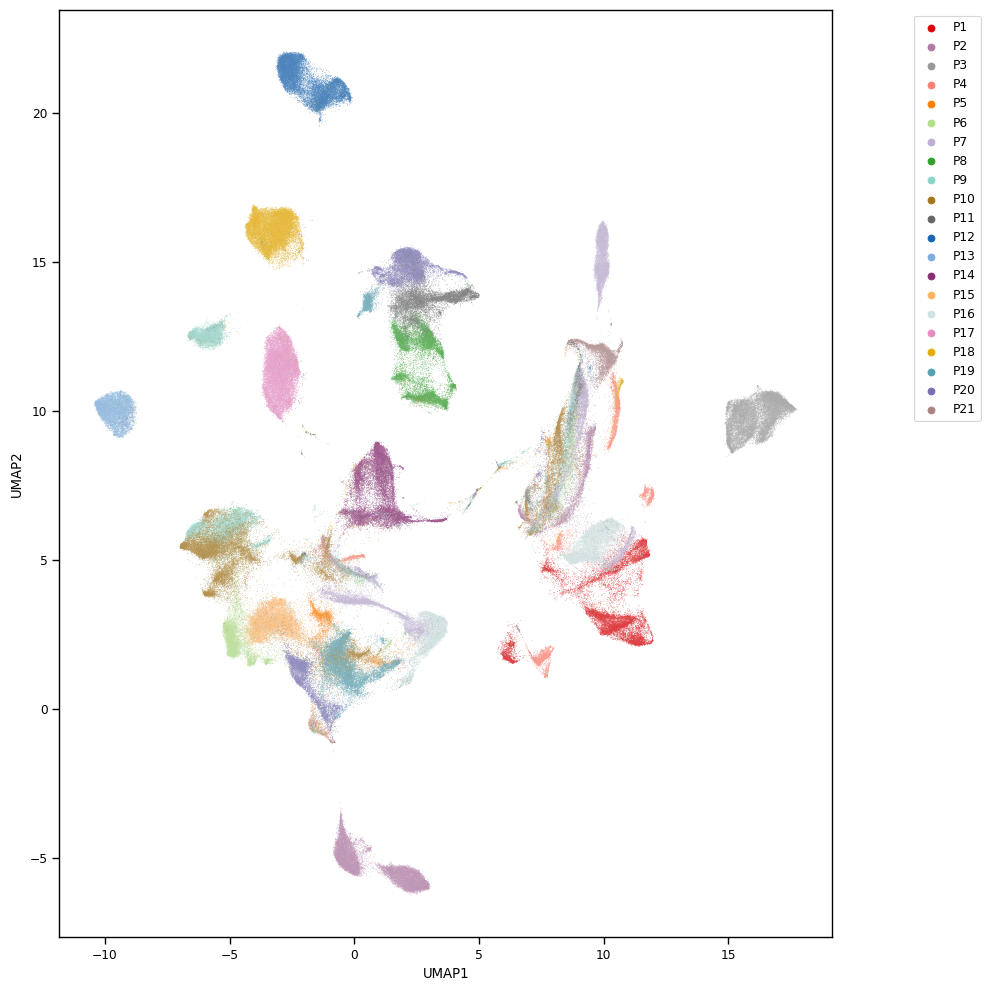

In [32]:
plt.figure(figsize=(10,10))

sns.scatterplot(data = run_meta, x="UMAP1", y="UMAP2", s=0.2, alpha=0.8, hue="PatientID", 
               palette=id_cmap, hue_order=sorted(run_meta["PatientID"].unique(), key=lambda x: int(x.replace("P", ""))))
plt.legend(bbox_to_anchor=(0.2,0,1,1))
plt.tight_layout()
plt.savefig("/Users/adr/Box/iPC_AML/Figures/updated_fcs/UMAPs/All_myeloid_cells_patient_id.png")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure1/All_myeloid_cells_patient_id.png",
           dpi=300)
plt.show()

In [33]:
timepoints_cmap

{'Diagnosis': '#DC2626',
 'EOI I': '#89AAFF',
 'Remission': '#89AAFF',
 'Relapse': '#433488',
 'Patient relapse': '#433488',
 'Patient diagnosis': '#DC2626',
 'All remission': '#89AAFF'}